In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion
import seaborn as sns

import tree
import sympy as sym
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from data import all_atom
from scipy.spatial.transform import Rotation
from model import basis_utils
from scipy.special import gamma
import pandas as pd

from omegaconf import OmegaConf
import importlib

Rigid = ru.Rigid
Rotation = ru.Rotation

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
from scipy.spatial.transform import Rotation

In [3]:
# Reloads any code changes to 
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(reverse_se3_diffusion)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [4]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 0
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 80

# Diffusion settings
diff_conf = conf.diffuser
diff_conf.diffuse_trans = True  # whether to diffuse translations
diff_conf.diffuse_rot = True  # whether to diffuse rotations
# Noise schedules
diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

diff_conf.trans_align_t = True

# print(OmegaConf.to_yaml(conf))

### Load data

In [5]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 17504663
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/02D_10M_2022Y_15h_23m_38s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [64 64 64 64 64 64 64 64 64 64]


In [6]:
train_iter = iter(train_loader)
next_item = next(train_iter)
# next_item = tree.map_structure(lambda x: x[0], next_item)

In [7]:
se3diff = exp._diffuser
r3diff = se3diff._r3_diffuser
so3diff = se3diff._so3_diffuser

In [78]:
(x0 - 1) * 3 + x0 * 3

tensor([-3., -3., -3.,  3., -3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,
        -3., -3., -3., -3., -3., -3.], dtype=torch.float64)

Text(95.72222222222221, 0.5, 'amino acid')

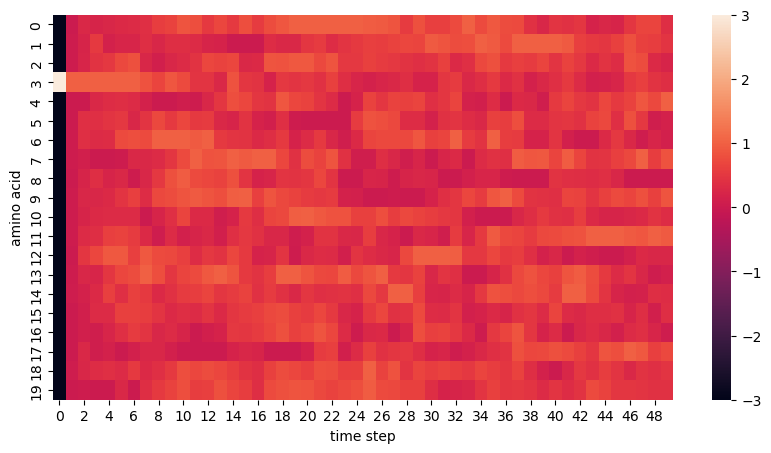

In [84]:
min_sigma = 0.1
max_sigma = 1.5
def sigma(t):
    # return min_sigma * (max_sigma / min_sigma)**t
    return np.log(t * np.exp(max_sigma) + (1 - t) * np.exp(min_sigma))
num_t = 50
ts = torch.linspace(1e-3, 1.0, num_t)


# aatype = torch.nn.functional.one_hot(
#     next_item['aatype'][0][2], num_classes=20).double()
# x0 = aatype[2]
x0 = torch.nn.functional.one_hot(
    next_item['aatype'][0][2], num_classes=20).double()
scale_factor = 3
x0 = (x0 - 1) * scale_factor + x0 * scale_factor


prob_traj = [x0]
xt_traj = [x0]
drift_traj = []
prev_t = None
for t in ts[:-1]:
    z = torch.normal(
        mean=torch.zeros_like(x0),
        std=torch.ones_like(x0)
    )
    if prev_t == None:
        drift = sigma(t) * z
    else:
        drift = torch.sqrt(sigma(t)**2 - sigma(prev_t)**2) * z
    drift_traj.append(drift)
    prev_t = t
    xt = prob_traj[-1] + drift
    prob_t = (xt - torch.min(xt)) / (torch.max(xt) - torch.min(xt))
    prob_traj.append(prob_t)
    xt_traj.append(xt)
prob_traj = du.move_to_np(torch.stack(prob_traj))
xt_traj = du.move_to_np(torch.stack(xt_traj))

plt.figure(figsize=(10, 5))
ax = sns.heatmap(prob_traj.T)
ax.set_xlabel('time step')
ax.set_ylabel('amino acid')

In [70]:
# plt.figure(figsize=(10, 5))
# ax = sns.heatmap(prob_traj.T)
# ax.set_xlabel('time step')
# ax.set_ylabel('amino acid')

In [ ]:
class SO3Diffuser:

    def __init__(self, so3_conf):
        self.schedule = so3_conf.schedule

        self.min_sigma = so3_conf.min_sigma
        self.max_sigma = so3_conf.max_sigma

        self.num_sigma = so3_conf.num_sigma
        self._log = logging.getLogger(__name__)

        # Discretize omegas for calculating CDFs. Skip omega=0.
        self.discrete_omega = np.linspace(0, np.pi, so3_conf.num_omega+1)[1:]

        self.equivariant_score = so3_conf.equivariant_score

        # Precompute IGSO3 values.
        replace_period = lambda x: str(x).replace('.', '_')
        cache_dir = os.path.join(
            so3_conf.cache_dir,
            f'eps_{so3_conf.num_sigma}_omega_{so3_conf.num_omega}_min_sigma_{replace_period(so3_conf.min_sigma)}_max_sigma_{replace_period(so3_conf.max_sigma)}_schedule_{so3_conf.schedule}'
        )

        # If cache directory doesn't exist, create it
        if not os.path.isdir(cache_dir):
            os.makedirs(cache_dir)
        pdf_cache = os.path.join(cache_dir, 'pdf_vals.npy')
        cdf_cache = os.path.join(cache_dir, 'cdf_vals.npy')
        score_norms_cache = os.path.join(cache_dir, 'score_norms.npy')

        if os.path.exists(pdf_cache) and os.path.exists(cdf_cache) and os.path.exists(score_norms_cache):
            self._log.info('Using cached IGSO3.')
            self._pdf = np.load(pdf_cache)
            self._cdf = np.load(cdf_cache)
            self._score_norms = np.load(score_norms_cache)
        else:
            self._log.info('Computing IGSO3.')
            # compute the expansion of the power series
            exp_vals = np.asarray(
                [igso3_expansion(self.discrete_omega, sigma) for sigma in self.discrete_sigma])
            # Compute the pdf and cdf values for the marginal distribution of the angle
            # of rotation (which is needed for sampling)
            self._pdf  = np.asarray(
                [density(x, self.discrete_omega, marginal=True) for x in exp_vals])
            self._cdf = np.asarray(
                [pdf.cumsum() / so3_conf.num_omega * np.pi for pdf in self._pdf])

            # Compute the norms of the scores.  This are used to scale the rotation axis when
            # computing the score as a vector.
            self._score_norms = np.asarray(
                [score(exp_vals[i], self.discrete_omega, x) for i, x in enumerate(self.discrete_sigma)])

            # Cache the precomputed values
            np.save(pdf_cache, self._pdf)
            np.save(cdf_cache, self._cdf)
            np.save(score_norms_cache, self._score_norms)

        if so3_conf.score_scaling == 'expected_norm':
            self._score_scaling = np.abs(
                np.sum(
                    self._score_norms * self._pdf, axis=-1) / np.sum(
                        self._pdf, axis=-1)
            )
        elif so3_conf.score_scaling == 'var':
            self._score_scaling = np.abs(
                np.sum(
                    self._score_norms**2 * self._pdf, axis=-1) / np.sum(
                        self._pdf, axis=-1)
            )
        elif so3_conf.score_scaling == 'std':
            self._score_scaling = np.sqrt(np.abs(
                np.sum(
                    self._score_norms**2 * self._pdf, axis=-1) / np.sum(
                        self._pdf, axis=-1)
            )) / np.sqrt(3)
        else:
            raise ValueError(f'Unrecognized score scaling {so3_conf.score_scaling}')

    @property
    def discrete_sigma(self):
        return self.sigma(
            np.linspace(0.0, 1.0, self.num_sigma)
        )

    def sigma_idx(self, sigma: np.ndarray):
        """Calculates the index for discretized sigma during IGSO(3) initialization."""
        return np.digitize(sigma, self.discrete_sigma) - 1

    def sigma(self, t: np.ndarray):
        """Extract \sigma(t) corresponding to chosen sigma schedule."""
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'exponential':
            sigma = t * np.log10(self.max_sigma) + (1 - t) * np.log10(self.min_sigma)
            return 10 ** sigma
        elif self.schedule == 'linear':
            return self.min_sigma + (self.max_sigma - self.min_sigma)*t
        elif self.schedule == 'logarithmic':
            return np.log(t * np.exp(self.max_sigma) + (1 - t) * np.exp(self.min_sigma))
        else:
            raise ValueError(f'Unrecognize schedule {self.schedule}')

    def diffusion_coef(self, t):
        """Compute diffusion coefficient (g_t)."""
        # TODO: Use autograd to get coefficients from sigma.
        if self.schedule == 'exponential':
            g_t = self.sigma(t) * np.sqrt(2 * np.log(self.max_sigma / self.min_sigma))
        elif self.schedule == 'linear':
            g_t = np.sqrt(2 * self.sigma(t) * (self.max_sigma - self.min_sigma))
        elif self.schedule == 'logarithmic':
            g_t = np.sqrt(
                2 * (np.exp(self.max_sigma) - np.exp(self.min_sigma)) * self.sigma(t) / np.exp(self.sigma(t))
            )
        else:
            raise ValueError(f'Unrecognize schedule {self.schedule}')
        return g_t

    def t_to_idx(self, t: np.ndarray):
        """Helper function to go from time t to corresponding sigma_idx."""
        return self.sigma_idx(self.sigma(t))

    def sample_igso3(
            self,
            t: float,
            n_samples: float=1):
        """Uses the inverse cdf to sample an angle of rotation from IGSO(3).

        Args:
            t: continuous time in [0, 1].
            n_samples: number of samples to draw.

        Returns:
            [n_samples] angles of rotation.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x = np.random.rand(n_samples)
        return np.interp(x, self._cdf[self.t_to_idx(t)], self.discrete_omega)

    def sample(
            self,
            t: float,
            n_samples: float=1):
        """Generates rotation vector(s) from IGSO(3).

        Args:
            t: continuous time in [0, 1].
            n_sample: number of samples to generate.

        Returns:
            [n_samples, 3] axis-angle rotation vectors sampled from IGSO(3).
        """
        x = np.random.randn(n_samples, 3)
        x /= np.linalg.norm(x, axis=-1, keepdims=True)
        return x * self.sample_igso3(t, n_samples=n_samples)[:, None]

    def sample_ref(self, n_samples: float=1):
        return self.sample(1, n_samples=n_samples)

    def score(
            self,
            vec: np.ndarray,
            t: float):
        """Computes the score of IGSO(3) density as a rotation vector.

        Args:
            vec: [..., 3] array of axis-angle rotation vectors.
            t: continuous time in [0, 1].

        Returns:
            [..., 3] score vector in the direction of the sampled vector with
            magnitude given by _score_norms.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        omega = np.linalg.norm(vec, axis=-1)
        return np.interp(
            omega, self.discrete_omega, self._score_norms[self.t_to_idx(t)]
        )[:, None] * vec / omega[:, None]

    def score_scaling(self, t: np.ndarray):
        """Calculates scaling used for scores during trianing."""
        return self._score_scaling[self.t_to_idx(t)]

    def forward_marginal(self, rots_0: np.ndarray, t: float):
        """Samples from the forward diffusion process at time index t.

        Args:
            rots_0: [..., 3] initial rotations.
            t: continuous time in [0, 1].

        Returns:
            rot_t: [..., 3] noised rotation vectors.
            rot_score: [..., 3] score of rot_t as a rotation vector.
        """
        n_samples = np.cumprod(rots_0.shape[:-1])[-1]
        sampled_rots = self.sample(t, n_samples=n_samples)
        rot_score = self.score(sampled_rots, t).reshape(rots_0.shape)

        if self.equivariant_score:
            # Left multiply.
            rot_t = du.compose_rotvec(sampled_rots, rots_0).reshape(rots_0.shape)
        else:
            # Right multiply.
            rot_t = du.compose_rotvec(rots_0, sampled_rots).reshape(rots_0.shape)
        return rot_t, rot_score

    def reverse(
            self,
            rot_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            add_noise: bool=True,
            mask: np.ndarray=None,
            ode: bool=False,
            ):
        """Simulates the reverse SDE for 1 step

        Args:
            rot_t: [..., 3] current rotations at time t.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            add_noise: set False to set diffusion coefficent to 0.
            mask: True indicates which residues to diffuse.
            ode: True indicates that the probability flow ode is to be used

        Returns:
            [..., 3] rotation vector at next step.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        g_t = self.diffusion_coef(t)
        if ode:
            # Probality flow ODE
            perturb = (1/2)*(g_t ** 2)* score_t * dt
        else:
            # Usual stochastic dynamics
            if add_noise:
                z = np.random.normal(size=score_t.shape)
            else:
                z = np.zeros_like(score_t)
            perturb = (g_t ** 2) * score_t * dt + g_t * np.sqrt(dt) * z

        if mask is not None: perturb *= mask[..., None]
        n_samples = np.cumprod(rot_t.shape[:-1])[-1]

        if self.equivariant_score:
            # Left multiply.
            rot_t_1 = du.compose_rotvec(
                perturb.reshape(n_samples, 3),
                rot_t.reshape(n_samples, 3),
            ).reshape(rot_t.shape)
        else:
            # Right multiply.
            rot_t_1 = du.compose_rotvec(
                rot_t.reshape(n_samples, 3),
                perturb.reshape(n_samples, 3)
            ).reshape(rot_t.shape)
        return rot_t_1


In [45]:
seq_conf = OmegaConf.create({
    'min_b': 0.1,
    'max_b': 20.0,
    'schedule': 'linear',
    'score_scaling': 'score_norm'
})
seq_diff = SequenceDiffuser(seq_conf)

In [83]:
one_hot_aatype = torch.nn.functional.one_hot(
    next_item['aatype'][0], num_classes=20)
one_hot_aatype = du.move_to_np(one_hot_aatype)

single_res = one_hot_aatype[1][None]
rescaled_res = 3*single_res - 1
diffused_aatype = []
discrete_t = np.linspace(1e-3, 1, 100)
for t in discrete_t:
    aatype_t = seq_diff.forward_marginal(
        rescaled_res, t
    )[0]
    diffused_aatype.append(aatype_t)
diffused_aatype = np.concatenate(diffused_aatype)

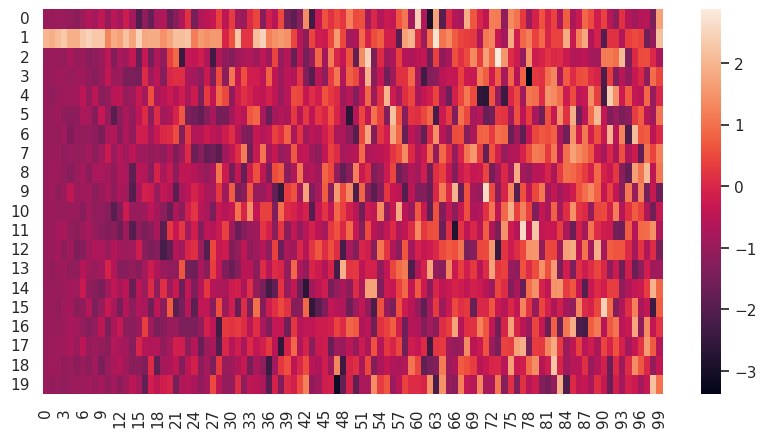

In [84]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(diffused_aatype.T)

In [42]:
class SequenceDiffuser:
    """VP-SDE diffuser class for translations."""

    def __init__(self, r3_conf):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self._r3_conf = r3_conf
        self.min_b = r3_conf.min_b
        self.max_b = r3_conf.max_b
        self.schedule = r3_conf.schedule
        self._score_scaling = r3_conf.score_scaling

    def b_t(self, t):
        if np.any(t < 0) or np.any(t > 1):
            raise ValueError(f'Invalid t={t}')
        if self.schedule == 'linear': 
            return self.min_b + t*(self.max_b - self.min_b)
        elif self.schedule == 'cosine':
            return self.max_b + 0.5*(self.min_b - self.max_b)*(1 + np.cos(t*np.pi))
        elif self.schedule == 'exponential':
            sigma = t * np.log10(self.max_b) + (1 - t) * np.log10(self.min_b)
            return 10 ** sigma
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')
    
    def diffusion_coef(self, t):
        """Time-dependent diffusion coefficient."""
        return np.sqrt(self.b_t(t))

    def drift_coef(self, x, t):
        """Time-dependent drift coefficient."""
        return -1/2 * self.b_t(t) * x

    def sample_ref(self, n_samples: float=1, vocab_size: float=21):
        return np.random.normal(size=(n_samples, vocab_size))

    def marginal_b_t(self, t):
        if self.schedule == 'linear':
            return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        elif self.schedule == 'exponential': 
            return (self.max_b**t * self.min_b**(1-t) - self.min_b) / (
                np.log(self.max_b) - np.log(self.min_b))
        else:
            raise ValueError(f'Unknown schedule {self.schedule}')

    def forward_marginal(self, x_0: np.ndarray, t: float):
        """Samples marginal p(x(t) | x(0)).

        Args:
            x_0: [..., n, 3] initial positions.
            t: continuous time in [0, 1]. 

        Returns:
            x_t: [..., n, 3] positions at time t.
            score_t: [..., n, 3] score at time t.
            score_scaling: [..., n,] scaling of scores.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        x_t = np.random.normal(
            loc=np.exp(-1/2*self.marginal_b_t(t)) * x_0,
            scale=np.sqrt(1 - np.exp(-self.marginal_b_t(t)))
        )
        score_t = self.score(x_t, x_0, t)
        return x_t, score_t

    def score_scaling(self, t: float):
        if self._score_scaling == 'var':
            return 1 / self.conditional_var(t)
        elif self._score_scaling == 'std':
            return 1 / np.sqrt(self.conditional_var(t))
        elif self._score_scaling == 'expected_norm':
            return np.sqrt(2) / (gamma(1.5) * np.sqrt(self.conditional_var(t)))
        else:
            raise ValueError(f'Unrecognized scaling {self._score_scaling}')

    def reverse(
            self,
            x_t: np.ndarray,
            score_t: np.ndarray,
            t: float,
            dt: float,
            add_noise: bool=True,
            mask: np.ndarray=None,
            center: bool=True,
            ode: bool=False):
        """Simulates the reverse SDE for 1 step

        Args:
            rot_t: [..., 3] current positions at time t.
            score_t: [..., 3] rotation score at time t.
            t: continuous time in [0, 1].
            dt: continuous step size in [0, 1].
            add_noise: set False to set diffusion coefficent to 0.
            mask: True indicates which residues to diffuse.

        Returns:
            [..., 3] positions at next step t-1.
        """
        if not np.isscalar(t):
            raise ValueError(f'{t} must be a scalar.')
        g_t = self.diffusion_coef(t)
        f_t = self.drift_coef(x_t, t)
        if ode:
            # Probability flow ODE
            perturb = (f_t - (1/2)*(g_t**2) * score_t) * dt
        else:
            # Usual stochastic dynamics
            if add_noise:
                z = np.random.normal(size=score_t.shape)
            else:
                z = np.zeros_like(score_t)
            perturb = (f_t - g_t**2 * score_t) * dt + g_t * np.sqrt(dt) * z

        if mask is not None:
            perturb *= mask[..., None]
        else:
            mask = np.ones(x_t.shape[:-1])
        x_t_1 = x_t - perturb
        if center:
            com = np.sum(x_t_1, axis=-2) / np.sum(mask, axis=-1)[..., None]
            x_t_1 -= com[..., None, :]
        return x_t_1

    def conditional_var(self, t):
        """Conditional variance of p(xt|x0).

        Var[x_t|x_0] = conditional_var(t)*I

        """
        return 1 - np.exp(-self.marginal_b_t(t))

    def score(self, x_t, x_0, t):
        return -(x_t - np.exp(-1/2*self.marginal_b_t(t)) * x_0) / self.conditional_var(t)
